In [1]:
import BLSTM_ATT
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Get data, 数据增强，在5-1中筛选了数据进行补充，其余作为测试数据

In [2]:
data = np.load('./databygroup.npy',allow_pickle=True).tolist()
#聚类筛选的数据，从step5-1中直接复制
TrainData,TestData={},{}
for k in data.keys():
    TrainData[k]=data[k]
    TestData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        xtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        ytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())
    #xtrain.append(xtem)
    #ytrain.append(ytem)
xtrain = Variable(torch.FloatTensor(xtrain))
ytrain = Variable(torch.FloatTensor(ytrain))
print(xtrain.shape,ytrain.shape)

torch.Size([34684, 20, 15]) torch.Size([34684, 5])


In [3]:
ind = np.random.randint(0,xtrain.shape[0],int(xtrain.shape[0]*0.7))
print(ind.shape)
np.save('./0.7alldata.npy',ind)

(24278,)


# Attention

## 训练

In [3]:
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':100, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.0001,
    'opt':'Adam',
    }

In [8]:
net = BLSTM_ATT.Net(param)
print(net)

ind = np.load('./0.7alldata.npy').tolist()
mask = np.ones(xtrain.shape[0], dtype=bool)
mask[ind] = False

optimizer = torch.optim.Adam(net.parameters(),lr = param['learning_rate'])
loss_func = torch.nn.MSELoss()
mse,vmse=[],[]
xt, yt = xtrain[ind], ytrain[ind]
xv, yv = xtrain[mask], ytrain[mask]

for t in range(1000):
    output = net(xtrain)
    loss = loss_func(output,ytrain)

    vp = net(xv)
    lossv = loss_func(vp,yv)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    mse.append(loss.detach().numpy())
    vmse.append(lossv.detach().numpy())
    print('Epoch:', t, ' Loss:',mse[-1],' vLoss:',vmse[-1])
    
    if np.mod(t,10)==0:
        np.save('./ATT_mse.npy',mse)
        np.save('./ATT_vmse.npy',vmse)

Net(
  (encoder): LSTM(15, 100, num_layers=4, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=200, out_features=5, bias=True)
)


KeyboardInterrupt: 

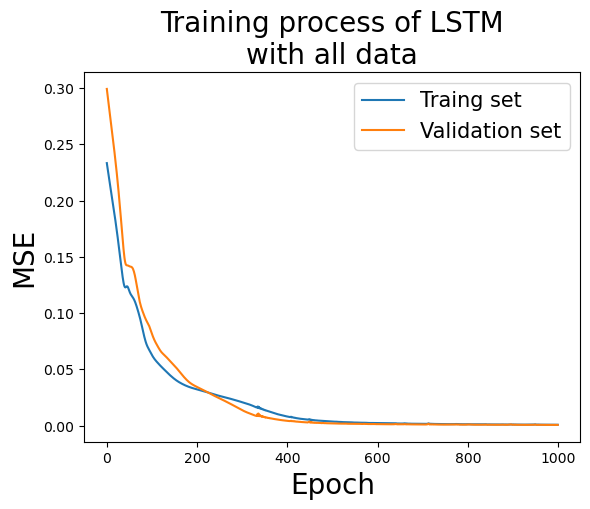

In [ ]:
#font1={'family':'Times New Roman','weight':'normal','size':20}
#font2={'family':'Times New Roman','weight':'normal','size':10}

font1={'weight':'normal','size':20}
font2={'weight':'normal','size':10}

plt.plot(mse,label='Traing set')
plt.plot(vmse,label='Validation set')
plt.title('Training process of LSTM'+'\n'+'with all data',font=font1)
plt.xlabel('Epoch',font=font1)
plt.ylabel('MSE',font=font1)
plt.legend(prop = {'size':15})
plt.savefig('./fig9-b.tif',bbox_inches = 'tight',dpi=200)